In [11]:
import numpy as np
import cv2
from typing import List, Tuple, Optional
import os
import matplotlib.pyplot as plt

In [12]:
def compute_gradient_scores(image: np.ndarray, 
                          patch_size: int = 64, 
                          stride: Optional[int] = None,
                          method: str = 'sobel',
                          color_mode: str = 'luminance') -> List[Tuple[int, int, float]]:
    """
    Calcule les scores de gradient pour chaque patch d'une image.
    
    Args:
        image: Image d'entrée (H, W, C) ou (H, W)
        patch_size: Taille des patchs (carrés)
        stride: Pas de déplacement entre les patchs (par défaut patch_size//2)
        method: Méthode de calcul du gradient ('sobel', 'scharr', 'laplacian')
        color_mode: Mode de calcul pour images couleur ('luminance', 'per_channel', 'max_channel')
    
    Returns:
        Liste de tuples (x, y, score) où x,y sont les coordonnées du patch
        et score est l'intensité du gradient
    """
    
    # Gestion des images couleur vs niveaux de gris
    if len(image.shape) == 3:
        if color_mode == 'luminance':
            # Conversion en luminance (préserve mieux les détails visuels)
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            gradient_magnitude = _compute_single_channel_gradient(gray, method)
            
        elif color_mode == 'per_channel':
            # Calcul du gradient sur chaque canal puis combinaison
            channels = cv2.split(image)
            gradients = []
            for channel in channels:
                grad = _compute_single_channel_gradient(channel, method)
                gradients.append(grad)
            # Moyenne des gradients des 3 canaux
            gradient_magnitude = np.mean(gradients, axis=0)
            
        elif color_mode == 'max_channel':
            # Prend le gradient maximum parmi les 3 canaux
            channels = cv2.split(image)
            gradients = []
            for channel in channels:
                grad = _compute_single_channel_gradient(channel, method)
                gradients.append(grad)
            gradient_magnitude = np.max(gradients, axis=0)
            
        else:
            raise ValueError("color_mode must be 'luminance', 'per_channel', or 'max_channel'")
    else:
        gradient_magnitude = _compute_single_channel_gradient(image, method)
    
    # Définition du stride
    if stride is None:
        stride = patch_size // 2
    
    h, w = gradient_magnitude.shape
    patch_scores = []
    
    # Extraction des patchs et calcul des scores
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            # Extraction du patch de gradient
            patch_gradient = gradient_magnitude[y:y+patch_size, x:x+patch_size]
            
            # Calcul du score (moyenne de l'intensité du gradient)
            score = np.mean(patch_gradient)
            
            patch_scores.append((x, y, score))
    
    return patch_scores

def _compute_single_channel_gradient(channel: np.ndarray, method: str) -> np.ndarray:
    """
    Calcule le gradient pour un canal unique.
    """
    # Normalisation
    channel = channel.astype(np.float32) / 255.0
    
    if method == 'sobel':
        grad_x = cv2.Sobel(channel, cv2.CV_32F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(channel, cv2.CV_32F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    elif method == 'scharr':
        grad_x = cv2.Scharr(channel, cv2.CV_32F, 1, 0)
        grad_y = cv2.Scharr(channel, cv2.CV_32F, 0, 1)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    elif method == 'laplacian':
        gradient_magnitude = cv2.Laplacian(channel, cv2.CV_32F)
        gradient_magnitude = np.abs(gradient_magnitude)
    
    else:
        raise ValueError("Method must be 'sobel', 'scharr', or 'laplacian'")
    
    return gradient_magnitude

def compute_color_gradient_scores(image: np.ndarray, 
                                patch_size: int = 64, 
                                stride: Optional[int] = None,
                                include_color_variance: bool = True,
                                gradient_weight: float = 0.7,
                                color_weight: float = 0.3) -> List[Tuple[int, int, float]]:
    """
    Calcule les scores combinant gradient et variance de couleur pour chaque patch.
    Particulièrement utile pour les œuvres d'art où la couleur est importante.
    
    Args:
        image: Image d'entrée (H, W, C)
        patch_size: Taille des patchs (carrés)
        stride: Pas de déplacement entre les patchs
        include_color_variance: Si True, inclut la variance de couleur dans le score
        gradient_weight: Poids du gradient dans le score final
        color_weight: Poids de la variance de couleur dans le score final
    
    Returns:
        Liste de tuples (x, y, score_total) avec scores combinés
    """
    
    if len(image.shape) != 3:
        raise ValueError("Cette fonction nécessite une image couleur (H, W, C)")
    
    # Calcul du gradient sur la luminance
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gradient_magnitude = _compute_single_channel_gradient(gray, 'sobel')
    
    # Définition du stride
    if stride is None:
        stride = patch_size // 2
    
    h, w = image.shape[:2]
    patch_scores = []
    
    # Extraction des patchs et calcul des scores
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            # Score de gradient
            patch_gradient = gradient_magnitude[y:y+patch_size, x:x+patch_size]
            gradient_score = np.mean(patch_gradient)
            
            if include_color_variance:
                # Score de variance de couleur
                patch_color = image[y:y+patch_size, x:x+patch_size, :]
                color_variance = np.mean([np.var(patch_color[:,:,c]) for c in range(3)])
                color_score = color_variance / 255.0  # Normalisation
                
                # Score combiné
                total_score = (gradient_weight * gradient_score + 
                              color_weight * color_score)
            else:
                total_score = gradient_score
            
            patch_scores.append((x, y, total_score))
    
    return patch_scores

def get_top_patches(patch_scores: List[Tuple[int, int, float]], 
                   top_k: int = 10) -> List[Tuple[int, int, float]]:
    """
    Retourne les k patchs avec les scores de gradient les plus élevés.
    
    Args:
        patch_scores: Liste des scores de patchs
        top_k: Nombre de patchs à retourner
    
    Returns:
        Liste des top k patchs triés par score décroissant
    """
    return sorted(patch_scores, key=lambda x: x[2], reverse=True)[:top_k]

def visualize_patches(image: np.ndarray, 
                     patch_scores: List[Tuple[int, int, float]], 
                     patch_size: int = 64,
                     top_k: int = 10,
                     show_all: bool = False):
    """
    Visualise les patchs avec les scores de gradient les plus élevés.
    
    Args:
        image: Image originale
        patch_scores: Liste des scores de patchs
        patch_size: Taille des patchs
        top_k: Nombre de patchs à afficher
        show_all: Si True, affiche tous les patchs avec une carte de chaleur
    """
    
    if show_all:
        # Création d'une carte de chaleur des scores
        h, w = image.shape[:2]
        heatmap = np.zeros((h, w))
        
        for x, y, score in patch_scores:
            heatmap[y:y+patch_size, x:x+patch_size] = np.maximum(
                heatmap[y:y+patch_size, x:x+patch_size], score
            )
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        axes[0].imshow(image)
        axes[0].set_title('Image originale')
        axes[0].axis('off')
        
        im = axes[1].imshow(heatmap, cmap='hot', alpha=0.7)
        axes[1].imshow(image, alpha=0.3)
        axes[1].set_title('Carte de chaleur des gradients')
        axes[1].axis('off')
        plt.colorbar(im, ax=axes[1])
        
    else:
        # Affichage des top k patchs
        top_patches = get_top_patches(patch_scores, top_k)
        
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.imshow(image)
        
        for i, (x, y, score) in enumerate(top_patches):
            # Dessiner un rectangle autour du patch
            rect = plt.Rectangle((x, y), patch_size, patch_size, 
                               fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            
            # Ajouter le score comme texte
            ax.text(x, y-5, f'{score:.3f}', color='red', fontweight='bold')
        
        ax.set_title(f'Top {top_k} patchs avec les gradients les plus élevés')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def extract_patches_array(image: np.ndarray, 
                         patch_scores: List[Tuple[int, int, float]], 
                         patch_size: int = 64,
                         top_k: Optional[int] = None) -> np.ndarray:
    """
    Extrait les patchs de l'image sous forme de tableau numpy.
    
    Args:
        image: Image originale
        patch_scores: Liste des scores de patchs
        patch_size: Taille des patchs
        top_k: Nombre de patchs à extraire (tous si None)
    
    Returns:
        Array numpy de shape (n_patches, patch_size, patch_size, channels)
    """
    
    if top_k is not None:
        patches_to_extract = get_top_patches(patch_scores, top_k)
    else:
        patches_to_extract = patch_scores
    
    patches = []
    for x, y, score in patches_to_extract:
        if len(image.shape) == 3:
            patch = image[y:y+patch_size, x:x+patch_size, :]
        else:
            patch = image[y:y+patch_size, x:x+patch_size]
        patches.append(patch)
    
    return np.array(patches)

def save_patches(image, patch_size, stride, save_dir, base_name):
    h, w, _ = image.shape
    patch_id = 0
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            patch_filename = f"{base_name}_patch_{patch_id}.jpg"
            patch_path = os.path.join(save_dir, patch_filename)
            cv2.imwrite(patch_path, cv2.cvtColor(patch, cv2.COLOR_RGB2BGR))
            patch_id += 1


In [13]:
patch_size = 64
stride = patch_size // 2

data_dir = "../Data"

image_extensions = (".jpg", ".jpeg", ".png")

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(image_extensions):
            image_path = os.path.join(root, file)
            print(f"Found image: {image_path}")

            image = cv2.imread(image_path)
            if image is None:
                print(f"Could not read image: {image_path}")
                continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Compute gradient magnitude (on luminance)
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            gradient_magnitude = _compute_single_channel_gradient(gray, 'sobel')
            break

Found image: ../Data/Tableau-peinture-Oeil.jpeg


In [34]:
def get_contour(image,kl):
    kernel_size = 2*kl+1
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 100)
    gradient = _compute_single_channel_gradient(blurred, 'sobel')
    return gradient

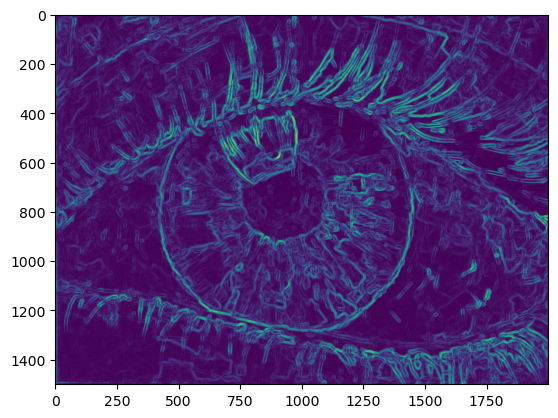

In [37]:
plt.imshow(get_contour(gray, 5))
plt.show()

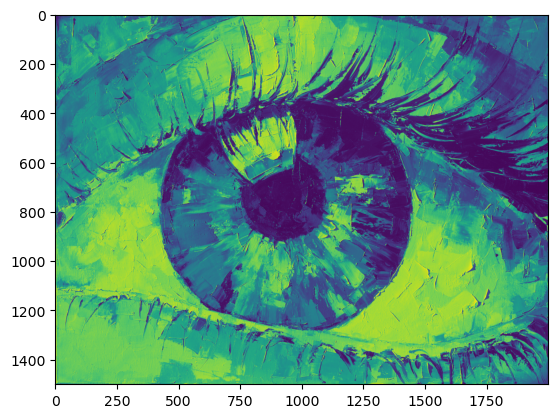

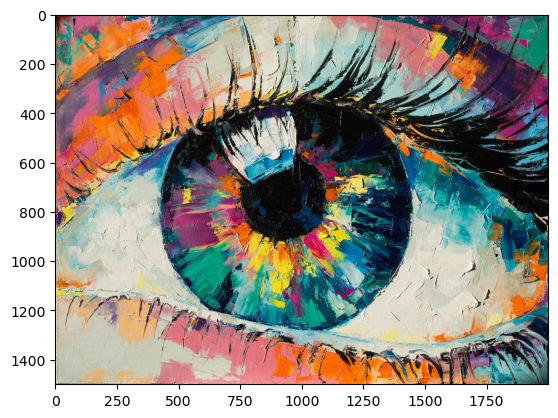

In [10]:
plt.imshow(gray)
plt.show()
plt.imshow(image)
plt.show()

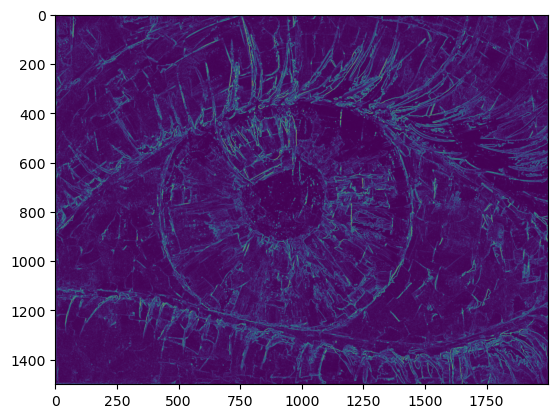

In [4]:
plt.imshow(gradient_magnitude)
plt.show()